<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imporitng-Required-Packages" data-toc-modified-id="Imporitng-Required-Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imporitng Required Packages</a></span></li><li><span><a href="#Importing-Dataset" data-toc-modified-id="Importing-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing Dataset</a></span></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train Test Split</a></span></li><li><span><a href="#SARIMA-Model" data-toc-modified-id="SARIMA-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SARIMA Model</a></span><ul class="toc-item"><li><span><a href="#Confirming-Stationarity" data-toc-modified-id="Confirming-Stationarity-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Confirming Stationarity</a></span></li><li><span><a href="#Estimating-initial-Parameters" data-toc-modified-id="Estimating-initial-Parameters-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Estimating initial Parameters</a></span></li><li><span><a href="#Model-Building-Function" data-toc-modified-id="Model-Building-Function-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Model Building Function</a></span></li><li><span><a href="#Non-Seasonal-Model" data-toc-modified-id="Non-Seasonal-Model-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Non Seasonal Model</a></span></li><li><span><a href="#Seasonal-Models" data-toc-modified-id="Seasonal-Models-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Seasonal Models</a></span></li><li><span><a href="#Accuracy-Comparision" data-toc-modified-id="Accuracy-Comparision-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Accuracy Comparision</a></span></li></ul></li><li><span><a href="#Final-SARIMA(1,-0,-1)-Model" data-toc-modified-id="Final-SARIMA(1,-0,-1)-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Final SARIMA(1, 0, 1) Model</a></span></li></ul></div>

# Imporitng Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import warnings

sns.set()
warnings.filterwarnings("ignore")

# Importing Dataset

In [2]:
file_path = "../data.csv"

In [3]:
data_backup = pd.read_csv(file_path)
data_backup.Date = pd.to_datetime(data_backup.Date)
data_backup.set_index("Date", inplace = True)

In [4]:
data = data_backup[["spx_ret"]]

# Train Test Split

In [5]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]

# SARIMA Model

In this section, the **SARIMA (Seasonal Auto-Regressive Integrated Moving-Average)** is built for the **SPX Returns**.

## Confirming Stationarity

Using the **ADF** Test the stationarity of **SPX Returns** is checked.

In [6]:
adfuller(train_df["spx_ret"][1:])

(-14.44375244632128,
 7.286951578520726e-27,
 34,
 6482,
 {'1%': -3.431359239667287,
  '5%': -2.8619859972456685,
  '10%': -2.5670074010110926},
 19945.163948739726)

The test statistic is less than all critical values and hence we can reject the Null Hypothesis ($H_0$: The series has a unit root).

Therefore, **SPX Returns** are **Stationary**

## Estimating initial Parameters

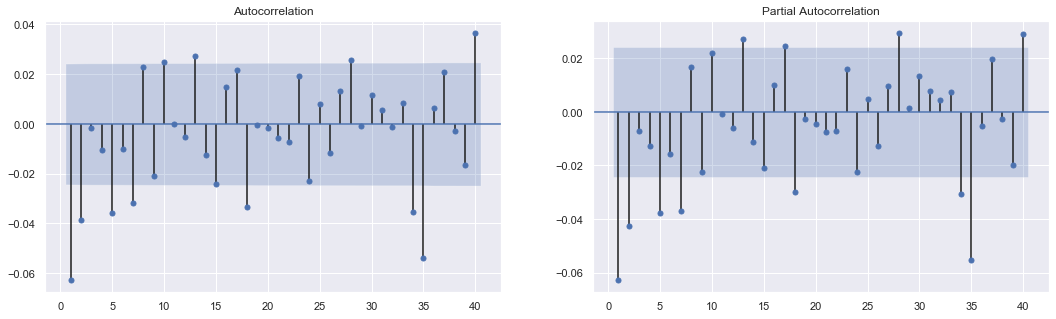

In [7]:
plt.rcParams["figure.figsize"] = 18, 5

fig, axes = plt.subplots(1, 2)

sgt.plot_acf(train_df.spx_ret[1:], zero = False, lags = 40, ax = axes[0])
sgt.plot_pacf(train_df.spx_ret[1:], zero = False, lags = 40, ax = axes[1])

plt.show()

Based on these plots and the EDA done previously - 
- The SPX Returns are stationary, so no need for differencing (seasonal or otherwise). So, $d = 0$ and/or $D = 0$
- The ACF and PACF plot clearly indicate that the data the first 2 lags are significant. So $p = 1$ or $p = 2$ could work for AR model. Similarly, $q = 1$ or $q = 2$ could work for the MA model.
- Lastly, the 5th lag is significant in both the plots. We know from EDA that we are dealing with financial data and hence some similar patterns are expected on a weekly basis (which consists of 5 days - business days). Thus, if seasonal models are used, then $P = 1$, $Q = 1$ and $M = 5$ are resonable guesses for the model parameters.

## Model Building Function

The following function is used to build SARIMA Models, print the model summary (optional), plot the predictions over some period (optional) and plot the ACF and PACF plots of residuals (optional).

In [8]:
def fit_seasonal_model(train_data, params, seasonal_params, 
                           verbose = False, plot_pred = False, plot_resid = False, 
                           start_date = "2019-01-01", end_date = "2019-08-30"):
    
    model = SARIMAX(train_data, order = params, seasonal_order = seasonal_params)
    model_results = model.fit()
    
    if verbose == True:
        print(model_results.summary())
    
    if plot_pred == True:
        pred = model_results.predict(start=start_date, end=end_date)
        
        plt.rcParams["figure.figsize"] = 18, 5
        data["spx_ret"][start_date:end_date].plot()
        pred[start_date:end_date].plot()
        plt.show()
    
    if plot_resid == True:
        plt.rcParams["figure.figsize"] = 18, 5

        fig, axes = plt.subplots(1, 2)

        sgt.plot_acf(model_results.resid[1:], zero = False, lags = 40, ax = axes[0])
        sgt.plot_pacf(model_results.resid[1:], zero = False, lags = 40, ax = axes[1])

        plt.show()
    
    return model_results

## Non Seasonal Model

First a simple Non Seasonal Model is built with the following parameters.
- $p = 1$
- $d = 0$
- $q = 1$

                               SARIMAX Results                                
Dep. Variable:                spx_ret   No. Observations:                 6518
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -10024.948
Date:                Fri, 06 Nov 2020   AIC                          20055.897
Time:                        08:28:12   BIC                          20076.244
Sample:                    01-06-1994   HQIC                         20062.933
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6462      0.047     13.689      0.000       0.554       0.739
ma.L1         -0.7075      0.043    -16.560      0.000      -0.791      -0.624
sigma2         1.2696      0.010    128.105      0.0

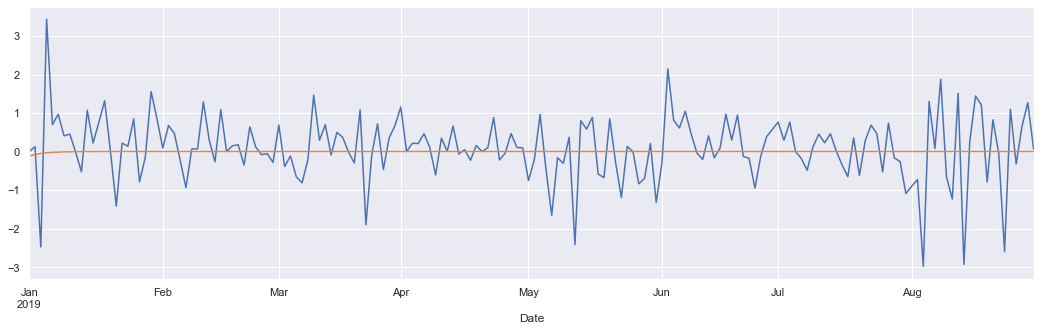

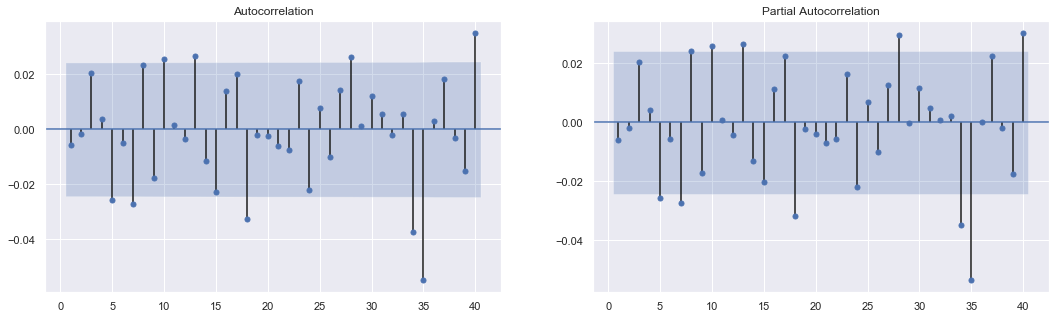

In [9]:
model_results = fit_seasonal_model(train_df, (1, 0, 1), (0, 0, 0, 0), 
                                   verbose = True, plot_pred = True, plot_resid = True, 
                                   start_date = test_df.index[0], end_date = test_df.index[-1])

## Seasonal Models

Now a seasonal component is added with the following parameters - 
- Non Seasonal Part
    - $p = 1$
    - $d = 1$
    - $q = 1$
- Seasonal Part
    - $P = 1$
    - $D = 1$
    - $Q = 1$
    - $M = 1$

                                     SARIMAX Results                                     
Dep. Variable:                           spx_ret   No. Observations:                 6517
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 5)   Log Likelihood              -10019.228
Date:                           Fri, 06 Nov 2020   AIC                          20048.456
Time:                                   08:28:31   BIC                          20082.366
Sample:                               01-07-1994   HQIC                         20060.183
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5426      0.062      8.815      0.000       0.422       0.663
ma.L1         -0.6075      0.057    -10.647

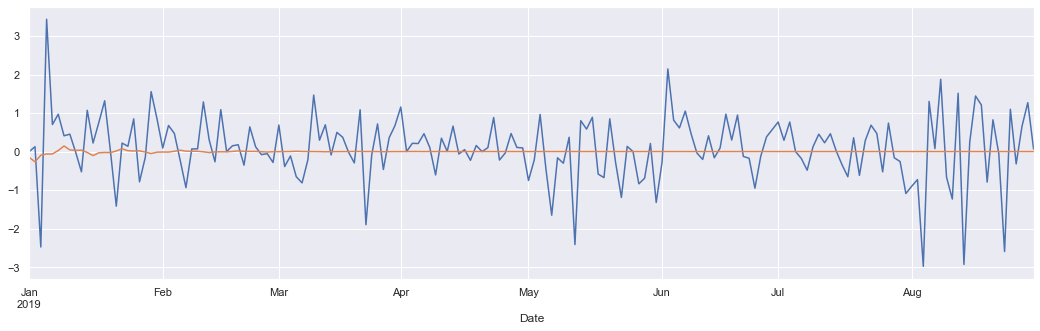

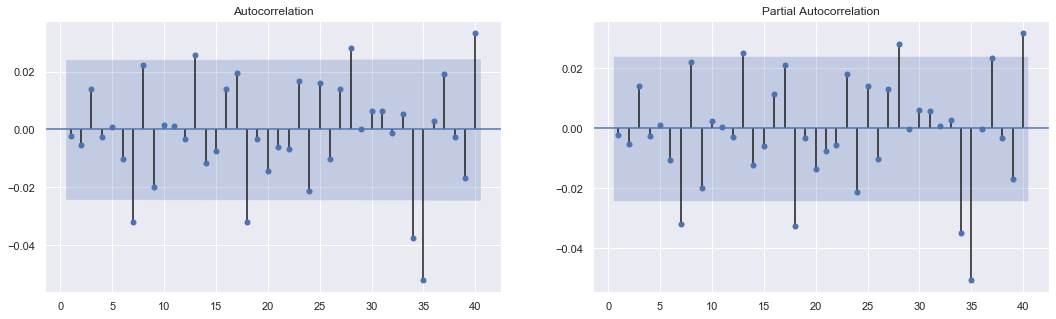

In [11]:
seasonal_model_results = fit_seasonal_model(train_df["spx_ret"][1:], (1, 0, 1), (1, 0, 1, 5), 
                                            verbose = True, plot_pred = True, plot_resid = True, 
                                            start_date = test_df.index[0], end_date = test_df.index[-1])

## Accuracy Comparision

Model Predictions for seasonal and non seasonal models.

In [12]:
non_seasonal_pred = model_results.predict(test_df.index[0], test_df.index[-1])
seasonal_pred = seasonal_model_results.predict(test_df.index[0], test_df.index[-1])

**RMSE** value for **Non Seasonal** Model.

In [13]:
np.sqrt(mean_squared_error(test_df["spx_ret"].values, non_seasonal_pred))

0.8593280336238088

**RMSE** value for **Seasonal** Model.

In [14]:
np.sqrt(mean_squared_error(test_df["spx_ret"].values, seasonal_pred))

0.8610574589440539

The **auto_arima** implemented in **pmdarima.arima** package of python also chooses the Non Seasonal Model implemented previously. Since the Non Seasonal Model is more simpler and has almost the same accuracy, it is the best SARIMA Model for this dataset.

# Final SARIMA(1, 0, 1) Model

**Defining the Final Model**

In [16]:
final_model = SARIMAX(train_df["spx_ret"][1:], order = (1, 0, 1))
final_model_results = final_model.fit()
final_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                spx_ret   No. Observations:                 6517
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -10024.948
Date:                Fri, 06 Nov 2020   AIC                          20055.897
Time:                        08:28:45   BIC                          20076.243
Sample:                    01-07-1994   HQIC                         20062.933
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6462      0.047     13.689      0.000       0.554       0.739
ma.L1         -0.7075      0.043    -16.560      0.000      -0.791      -0.624
sigma2         1.2696      0.010    128.105      0.000       1.250       1.289
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):             20322.56
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Setting the Prediction Interval.**

In [17]:
start_date, end_date = test_df.index[0], test_df.index[-1]

**Predictions**

In [18]:
final_forecast = final_model_results.get_forecast(len(test_df.index))
final_predictions_df = final_forecast.conf_int(alpha = 0.05) # Confidence level of 95%
final_predictions_df["Predictions"] = final_model_results.predict(start = start_date, end = end_date)

**Plot of Predicted vs Actual Values**

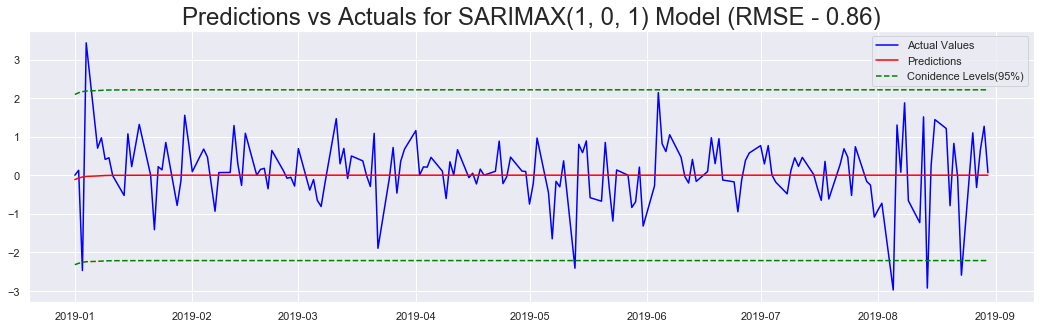

In [19]:
final_rmse = np.sqrt(mean_squared_error(test_df["spx_ret"].values, final_predictions_df["Predictions"]))

plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["spx_ret"][start_date:end_date], color = "blue", label = "Actual Values")

plt.plot(final_predictions_df["Predictions"][start_date:end_date], color = "red", label = "Predictions")
plt.plot(final_predictions_df["upper spx_ret"][start_date:end_date], color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(final_predictions_df["lower spx_ret"][start_date:end_date], color = "green", linestyle = "--")

plt.title(f"Predictions vs Actuals for SARIMAX(1, 0, 1) Model (RMSE - {round(final_rmse, 2)})", size = 24)

plt.legend()
plt.show()